In [154]:
import torch
import torchvision
from torchvision.datasets import MNIST

import torchvision.transforms as transforms

from torch.utils.data import random_split

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [155]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())
#len(dataset)

In [156]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

In [157]:
batch_size = 32

In [158]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device

In [159]:
def train(model, device, train_loader, optimizer, loss_fn, epoch):
    model.train()
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

In [160]:
def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [161]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

    def decode(self, x):
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
        return x
      
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

model = ConvAutoencoder()
device = "cuda"
model.to(device)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [162]:
train_data = [(d[0], d[0]) for d in train_ds]
val_data = [(d[0], d[0]) for d in val_ds]

In [163]:
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size)

In [164]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [165]:
for i in range(10):
  train(model, device, train_loader, optimizer, criterion, epoch=i)

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


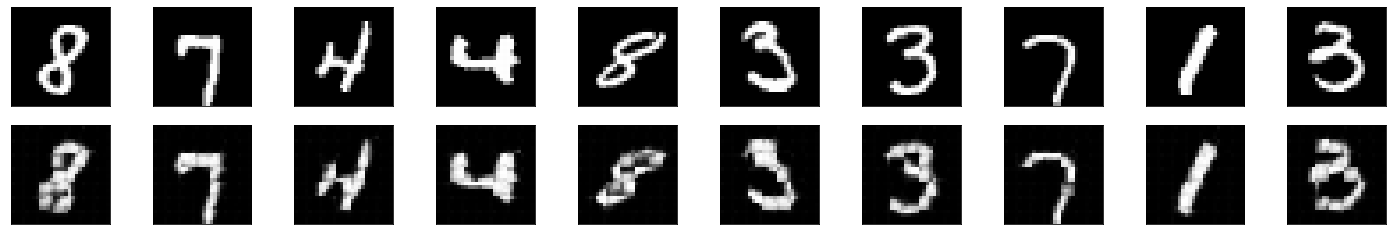

In [166]:
dataiter = iter(val_loader)
images, labels = dataiter.next()


output = model(images.to(device))
images = images.cpu().numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.cpu().detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)